In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping,ReduceLROnPlateau #Import callback functions

In [ ]:
data='/content/drive/MyDrive/Source Code/dataset/Train/'

In [ ]:
batch_size = 32
img_height = 224
img_width = 224

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(zoom_range=0.15,width_shift_range=0.2,shear_range=0.15)
test_datagen = ImageDataGenerator()
#Setting train/test split

train = train_datagen.flow_from_directory(data, target_size=(img_height, img_width),
                                                     class_mode="categorical", batch_size=batch_size, subset="training")
test = test_datagen.flow_from_directory(data, target_size=(img_height, img_width),
                                                    class_mode="categorical", batch_size=batch_size, shuffle=False)

Found 2041 images belonging to 2 classes.
Found 2041 images belonging to 2 classes.


In [ ]:
classess = train.num_classes
classess

2

In [ ]:
Mobilenet = MobileNet(weights='imagenet', include_top = False, input_shape = (224,224,3))

17225924/17225924 [==============================] - 0s 0us/step


In [ ]:
for i in Mobilenet.layers:
    i.trainable = False

In [ ]:
def main_model(tl_model,classess):
    m_model = tl_model.output
    m_model = GlobalAveragePooling2D()(m_model)
    m_model = Dense(1024,activation='relu')(m_model)
    m_model = Dense(1024,activation='relu')(m_model)
    m_model = Dense(512,activation='relu')(m_model)
    m_model = Dense(classess,activation = 'softmax')(m_model)
    return m_model

In [ ]:
combining_model = main_model(Mobilenet,classess)

In [ ]:
model = Model(inputs=Mobilenet.input, outputs=combining_model)

In [ ]:
model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128   

In [ ]:
earlystop=EarlyStopping(patience=10) #Monitor the performance. If it dips, then stop training
learning_rate_reduce=ReduceLROnPlateau(monitor="val_accuracy",min_lr=0.001) #Change learning rate if not performing good enough
callbacks=[earlystop,learning_rate_reduce]

In [ ]:
history = model.fit(train, validation_data=test, epochs=20)

Epoch 1/20
64/64 [==============================] - 323s 5s/step - loss: 0.7930 - accuracy: 0.5341 - val_loss: 0.6648 - val_accuracy: 0.6090
Epoch 2/20
64/64 [==============================] - 69s 1s/step - loss: 0.6789 - accuracy: 0.5772 - val_loss: 0.6789 - val_accuracy: 0.5507
Epoch 3/20
64/64 [==============================] - 70s 1s/step - loss: 0.6700 - accuracy: 0.6022 - val_loss: 0.6487 - val_accuracy: 0.6120
Epoch 4/20
64/64 [==============================] - 70s 1s/step - loss: 0.6589 - accuracy: 0.6129 - val_loss: 0.6279 - val_accuracy: 0.6654
Epoch 5/20
64/64 [==============================] - 71s 1s/step - loss: 0.6409 - accuracy: 0.6374 - val_loss: 0.6080 - val_accuracy: 0.6663
Epoch 6/20
64/64 [==============================] - 88s 1s/step - loss: 0.6440 - accuracy: 0.6423 - val_loss: 0.6359 - val_accuracy: 0.6056
Epoch 7/20
64/64 [==============================] - 69s 1s/step - loss: 0.6332 - accuracy: 0.6448 - val_loss: 0.6235 - val_accuracy: 0.6389
Epoch 8/20
64/64 [=

In [ ]:
model.save("mobilent_project.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
test_score = model.evaluate(test)

64/64 [==============================] - 24s 376ms/step - loss: 0.5370 - accuracy: 0.7202


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools


target_names = []
for key in train.class_indices:
    target_names.append(key)

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    plt.figure(figsize=(10,10))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

64/64 [==============================] - 28s 426ms/step
Confusion Matrix
Confusion matrix, without normalization


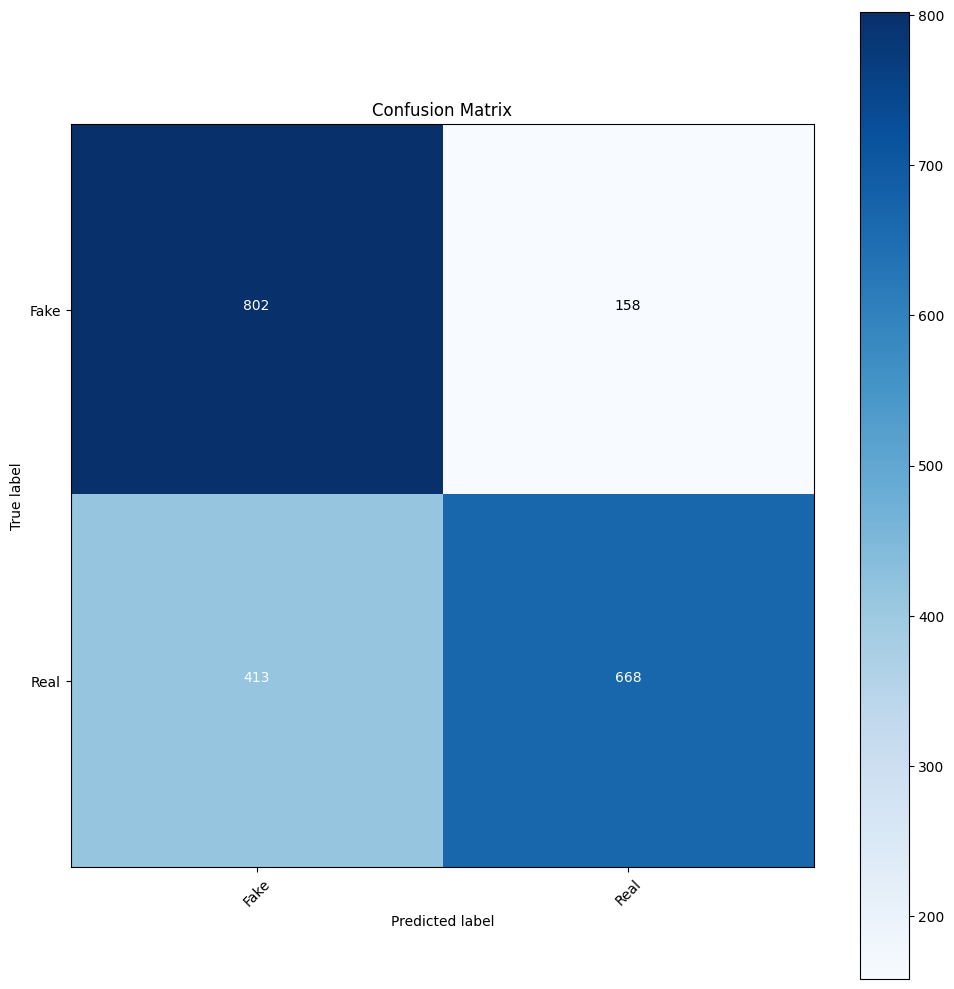

In [ ]:
#Confution Matrix and Classification Report
Y_pred = model.predict(test)
y_pred = np.argmax(Y_pred, axis=-1)
print('Confusion Matrix')
cm=confusion_matrix(test.classes, y_pred)

plot_confusion_matrix(cm, target_names, title='Confusion Matrix')


In [ ]:
print('Classification Report')
print(classification_report(test.classes, y_pred, target_names=target_names, digits=4))

Classification Report
              precision    recall  f1-score   support

        Fake     0.6601    0.8354    0.7375       960
        Real     0.8087    0.6179    0.7006      1081

    accuracy                         0.7202      2041
   macro avg     0.7344    0.7267    0.7190      2041
weighted avg     0.7388    0.7202    0.7179      2041



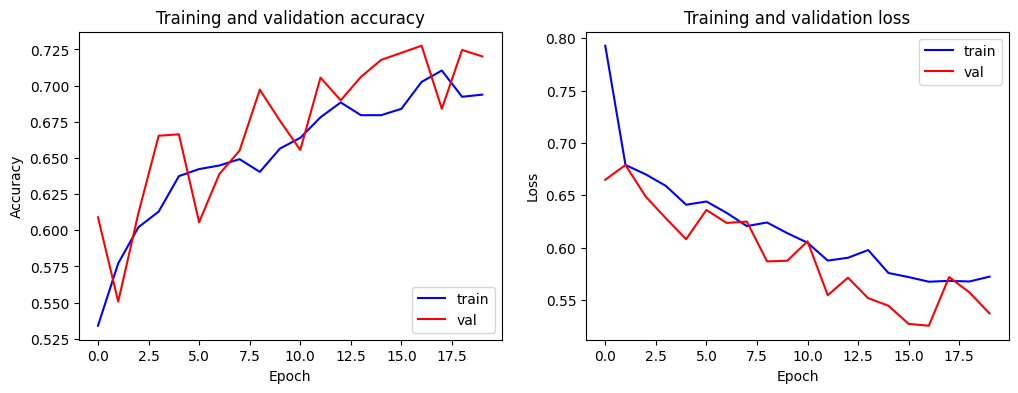

In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(train_accuracy))
plt.figure(figsize=(12,4))

# Plotting the accuracy
plt.subplot(1,2,1)
plt.plot(epochs, train_accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='lower right')

# Plotting the loss
plt.subplot(1,2,2)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper right')

plt.show()

In [ ]:
labels = train.class_indices
final_labels = {v: k for k, v in labels.items()}
final_labels

{0: 'Fake', 1: 'Real'}

In [ ]:
from tensorflow.keras.models import load_model
import ast
from tensorflow.keras.preprocessing import image

In [ ]:
def predict_image(imgname, from_test_dir):
    test_image = image.load_img(imgname, target_size = (224, 224))

    plt.imshow(test_image)
    plt.show()

    test_image = np.asarray(test_image)
    test_image = np.expand_dims(test_image, axis=0)
    result = model.predict(test_image)

    result_dict = dict()
    for key in list(final_labels.keys()):
        result_dict[final_labels[key]] = result[0][key]
    sorted_results = {k: v for k, v in sorted(result_dict.items(), key=lambda item: item[1], reverse=True)}

    if not from_test_dir:
        print('=' * 50)
        for label in sorted_results.keys():
            print("{}: {}%".format(label, sorted_results[label] * 100))

    final_result = dict()
    final_result[list(sorted_results.keys())[0]] = sorted_results[list(sorted_results.keys())[0]] * 100

    return final_result




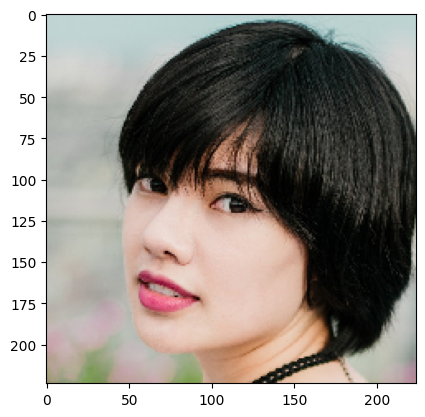

1/1 [==============================] - 1s 906ms/step
Real: 74.83933568000793%
Fake: 25.160661339759827%
Final Result:  {'Real': 74.83933568000793}


In [ ]:
final_result1 = predict_image('/content/drive/MyDrive/Source Code/dataset/Train/Real/real_00018.jpg', False)
print("Final Result: ", final_result1)


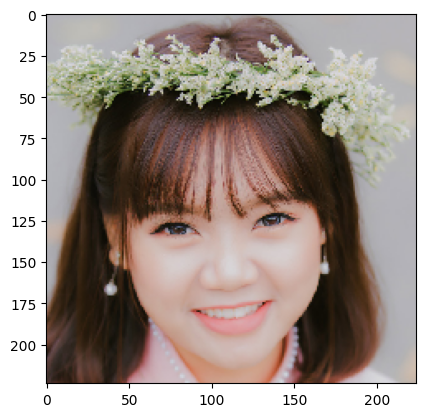

1/1 [==============================] - 0s 29ms/step
Fake: 79.54899072647095%
Real: 20.45101225376129%
Final Result:  {'Fake': 79.54899072647095}


In [ ]:
final_result2 = predict_image('/content/drive/MyDrive/Source Code/dataset/Train/Real/real_00052.jpg', False)
print("Final Result: ", final_result2)


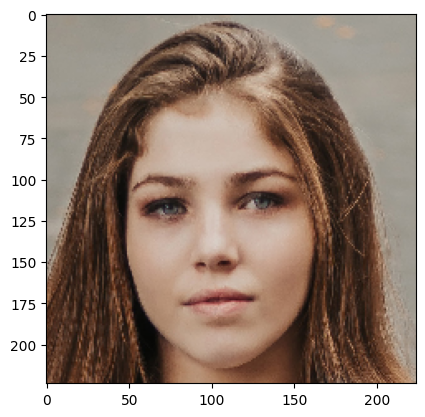

1/1 [==============================] - 0s 24ms/step
Fake: 75.87264776229858%
Real: 24.127350747585297%
Final Result:  {'Fake': 75.87264776229858}


In [ ]:
final_result3 = predict_image('/content/drive/MyDrive/Source Code/dataset/Train/Real/real_00107.jpg', False)
print("Final Result: ", final_result3)

In [ ]:
import shutil
import os

t = '/content/drive/MyDrive/Source Code/Model-20-Epochs/'


os.makedirs(t)
shutil.copy('/content/mobilent_project.h5', t)

'/content/drive/MyDrive/Source Code/Model-20-Epochs/mobilent_project.h5'